# Image Captioning with Transformers
### Encoder-Decoder Architecture

<img src="../data/llm_architecture_comparison.png" width="600" align="center">
<br>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

import tensorflow as tf
import cv2 

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [6]:
!pip install pycocotools

In [7]:
!pip install gtts

^C
ERROR: Operation cancelled by user


In [8]:
from pycocotools.coco import COCO

In [9]:
learning_rate = 1e-4

image_size = 128

nepochs = 120

batch_size = 128


data_set_root ='/kaggle/input/coco-image-caption'
train_set ='train2014/train2014'
 
validation_set = 'val2017/val2017'
train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json'
val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json'

## Data processing and Tokenization

In [10]:
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [13]:
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)]) 

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_image_path,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
dataiter = next(iter(data_loader_val))

test_images, test_captions = dataiter

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


a tennis player swinging at the tennis ball


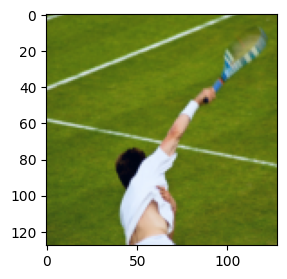

In [15]:
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)

In [16]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
tokenizer.vocab_size

30522

In [18]:
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

In [19]:
tokens['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [20]:
token_ids = tokens['input_ids'][0]
tokens['input_ids']

tensor([[ 101, 1037, 5093,  ...,    0,    0,    0],
        [ 101, 1037, 2644,  ...,    0,    0,    0],
        [ 101, 1037, 2158,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 3902,  ...,    0,    0,    0],
        [ 101, 1037, 2177,  ...,    0,    0,    0],
        [ 101, 1037, 4628,  ...,    0,    0,    0]])

In [21]:
print(tokenizer.decode(token_ids))

[CLS] a tennis player swinging at the tennis ball [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [22]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Create Encoder-Decoder Network

In [23]:
def extract_patches(image_tensor, patch_size=16):
    bs, c, h, w = image_tensor.size()
    
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    unfolded = unfold(image_tensor)
    
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        self.norm1 = nn.LayerNorm(hidden_size)
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        self.norm_mlp = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        self.embedding = nn.Embedding(num_emb, hidden_size)

        torch.nn.init.normal_(self.embedding.weight, mean=0, std=0.01)

        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

    
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, 
                                                      hidden_size).normal_(std=0.02))
        
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=False, masking=False) for _ in range(num_layers)
        ])
                
    def forward(self, image):  
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        embs = patch_emb + self.pos_embedding
        
        for block in self.blocks:
            embs = block(embs)
        
        return embs
    
    
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
                                     patch_size=patch_size, hidden_size=hidden_size, 
                                     num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        bool_padding_mask = padding_mask == 0

        encoded_seq = self.encoder(image=input_image)
        
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

## Initialise Model and Optimizer

In [24]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

hidden_size = 192

num_layers = (6, 6)

num_heads = 8

patch_size = 8

caption_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, patch_size=patch_size, 
                                     num_layers=num_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

training_loss_logger = []

/tmp/ipykernel_31/1146272611.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [25]:
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 18067194 (Approximately 18 Million) Parameters!


## Training

In [399]:
checkpoint_dir = "/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in trange(0, nepochs, leave=False, desc="Epoch"):
    caption_model.train()
    steps = 0
    for images, captions in tqdm(data_loader_train, desc="Training", leave=False):
        
        images = images.to(device)
        
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]
        
        target_ids = torch.cat((token_ids[:, 1:], 
                                torch.zeros(bs, 1, device=device).long()), 1)
        
        tokens_in = td(token_ids)
        with torch.cuda.amp.autocast():
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)

        loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        training_loss_logger.append(loss.item())

    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"caption_model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': caption_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)
        print(f"Model checkpoint saved at epoch {epoch + 1} to {checkpoint_path}")


Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

/tmp/ipykernel_30/2900425380.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79170862a680>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/li

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Plot Loss

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[100:])
_ = plt.title("Training Loss")

In [ ]:
window_size = 512
data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode="valid")
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(data[:])
_ = plt.title("Training Loss")

## Testing

In [26]:
model_path = '/kaggle/input/image-captioning-120/caption_model_epoch_120.pth'
checkpoint = torch.load(model_path)

caption_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])

/tmp/ipykernel_31/2101928603.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [27]:
IMAGE_SIZE = (128, 128)  # Resize images to match the input size of your model (e.g., for InceptionV3).
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    image = tf.image.resize(image, IMAGE_SIZE)
    
    image = image / 255.0
    
    image = (image - MEAN) / STD
    
    image = tf.expand_dims(image, axis=0)
    
    image = image.numpy()
    
    image = torch.from_numpy(image)
    
    image = image.permute(0,3,1,2)
    
    return image

In [28]:
IMAGE_SIZE = (128, 128)  # Resize images to match the input size of your model.
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def preprocess_vid(frame):
    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

    frame = tf.image.resize(frame, IMAGE_SIZE)

    frame = frame / 255.0

    frame = (frame - MEAN) / STD

    frame = tf.expand_dims(frame, axis=0)

    frame = frame.numpy()
    frame = torch.from_numpy(frame)

    frame = frame.permute(0, 3, 1, 2)

    return frame

In [29]:
def display(image_path):

    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [30]:
def test(test_image):
    sos_token = 101 * torch.ones(1, 1).long()

    temp = 1.0

    log_tokens = [sos_token]
    caption_model.eval()
    torch.set_grad_enabled(False)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            image_embedding = caption_model.encoder(test_image.to(device))

        for i in range(50):
            input_tokens = torch.cat(log_tokens, 1)

            data_pred = caption_model.decoder(input_tokens.to(device), image_embedding)
    
            if torch.isnan(data_pred).any():
                continue
    
            clipped_logits = torch.clamp(data_pred[:, -1], min=-100, max=100)
            dist = Categorical(logits=clipped_logits / temp)
            next_tokens = dist.sample().reshape(1, 1)

            log_tokens.append(next_tokens.cpu())

            if next_tokens.item() == 102:
                break
                
    pred_text = torch.cat(log_tokens, 1)

    pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

    pred_text = "".join(pred_text_strings)

    print(pred_text)
    
    return pred_text

In [ ]:
folder_path = '/kaggle/input/random-images'

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    test_image = preprocess_image(file_path).to(device)
    test(test_image)
    display(file_path)

/tmp/ipykernel_31/2826200707.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


a baby bird sitting next to a broken tree with a bird flying in the background.


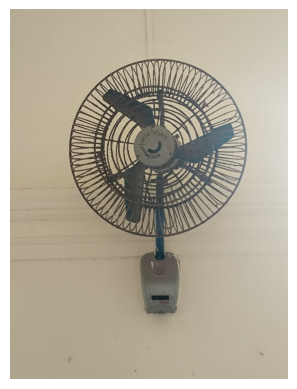

In [82]:
file_path = "/kaggle/input/clg-images/t3.jpg"
test_image = preprocess_image(file_path).to(device)
ans = test(test_image)
display(file_path)

In [50]:
from gtts import gTTS
import os

text = ans

language = 'en'  # Use 'en' for English, or any language code like 'es', 'fr', etc.

tts = gTTS(text=text, lang=language, slow=False)  # slow=False for normal speed

tts.save("output.mp3")

os.system("start output.mp3")  # Use 'xdg-open' for Linux or 'open' for macOS


sh: 1: start: not found


32512

In [72]:
input_video_path = '/kaggle/input/test-video-cycling/Cycling.mp4'
cap = cv2.VideoCapture(input_video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

i = 0

while True:
    ret, frame = cap.read()
    i += 1
    if not ret:
        break  # Exit loop if no frame is read

    if i % 5 == 0:
        frame = preprocess_vid(frame).to(device)

        test(frame)

/tmp/ipykernel_30/4089330330.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


several bottles of different colored scissors in a blue toilet.
person in a purple jacket holding a green frisbee.
bicycle and bicycle locked to a store display store and a tropical display.
pointing upwards, going tennis waves on the ball and a demon image.
a number of baseball bats laying on top of each other
a sign on the side of the road during the cell
an elderly man in a jail cell route and music on his head.
a bunch of street signs mounted to a wall.
signs on a tree beside the pedestrian street sign.
as a tall saying va walks up from a bunch of speakers
three ties on them are hooks for different colors.
##gr machines exactly manuals, keys, pencils, and computer mouse
